In [144]:
# Cell 0: Create extended synthetic dataset (only if you don't already have it)
import numpy as np
import pandas as pd
np.random.seed(42)

n_samples = 3000
age = np.random.randint(10, 90, n_samples)
gender = np.random.choice(['Male', 'Female'], n_samples, p=[0.49, 0.51])

fever = np.random.binomial(1, 0.35, n_samples)
cough = np.random.binomial(1, 0.4, n_samples)
short_breath = np.random.binomial(1, 0.15, n_samples)
loss_smell = np.random.binomial(1, 0.12, n_samples)
fatigue = np.random.binomial(1, 0.3, n_samples)
headache = np.random.binomial(1, 0.25, n_samples)
sore_throat = np.random.binomial(1, 0.2, n_samples)
nausea = np.random.binomial(1, 0.08, n_samples)
chest_pain = np.random.binomial(1, 0.03, n_samples)

diabetes = np.random.binomial(1, 0.12, n_samples)
hypertension = np.random.binomial(1, 0.18, n_samples)

base_prob = 0.07
score = (base_prob
         + 0.18*fever
         + 0.15*cough
         + 0.25*loss_smell
         + 0.20*short_breath
         + 0.08*fatigue
         + 0.05*headache
         + 0.10*sore_throat
         + 0.06*diabetes
         + 0.06*hypertension)
score = np.clip(score, 0, 0.95)
covid_positive = (np.random.rand(n_samples) < score).astype(int)

df = pd.DataFrame({
    'age': age,
    'gender': gender,
    'fever': fever,
    'cough': cough,
    'short_breath': short_breath,
    'loss_of_taste_smell': loss_smell,
    'fatigue': fatigue,
    'headache': headache,
    'sore_throat': sore_throat,
    'nausea': nausea,
    'chest_pain': chest_pain,
    'diabetes': diabetes,
    'hypertension': hypertension,
    'covid_positive': covid_positive
})

out_path = "patient_symptoms_covid_extended.csv"
df.to_csv(out_path, index=False)
print("Saved:", out_path)
print("Positive fraction:", df['covid_positive'].mean())
df.head()


Saved: patient_symptoms_covid_extended.csv
Positive fraction: 0.319


,age,gender,fever,cough,short_breath,loss_of_taste_smell,fatigue,headache,sore_throat,nausea,chest_pain,diabetes,hypertension,covid_positive
0,61,Male,0,0,0,0,0,0,0,0,0,0,0,0
1,24,Female,0,1,0,0,0,1,0,0,0,0,0,0
2,81,Female,1,1,0,0,1,0,0,0,0,0,1,0
3,70,Male,0,0,0,0,1,0,0,0,0,0,0,1
4,30,Male,1,1,0,0,1,0,0,0,0,0,0,0


In [145]:
import pandas as pd
import numpy as np


In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [148]:
df = pd.read_csv("patient_symptoms_covid_extended.csv")

In [149]:
df.head()

,age,gender,fever,cough,short_breath,loss_of_taste_smell,fatigue,headache,sore_throat,nausea,chest_pain,diabetes,hypertension,covid_positive
0,61,Male,0,0,0,0,0,0,0,0,0,0,0,0
1,24,Female,0,1,0,0,0,1,0,0,0,0,0,0
2,81,Female,1,1,0,0,1,0,0,0,0,0,1,0
3,70,Male,0,0,0,0,1,0,0,0,0,0,0,1
4,30,Male,1,1,0,0,1,0,0,0,0,0,0,0


In [150]:
df.shape


(3000, 14)

In [151]:
df['covid_positive'].mean()

np.float64(0.319)

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  3000 non-null   int64 
 1   gender               3000 non-null   object
 2   fever                3000 non-null   int64 
 3   cough                3000 non-null   int64 
 4   short_breath         3000 non-null   int64 
 5   loss_of_taste_smell  3000 non-null   int64 
 6   fatigue              3000 non-null   int64 
 7   headache             3000 non-null   int64 
 8   sore_throat          3000 non-null   int64 
 9   nausea               3000 non-null   int64 
 10  chest_pain           3000 non-null   int64 
 11  diabetes             3000 non-null   int64 
 12  hypertension         3000 non-null   int64 
 13  covid_positive       3000 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 328.3+ KB


In [153]:
df.describe()

,age,fever,cough,short_breath,loss_of_taste_smell,fatigue,headache,sore_throat,nausea,chest_pain,diabetes,hypertension,covid_positive
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,48.324000,0.332333,0.392333,0.157333,0.119667,0.312667,0.263333,0.193000,0.067000,0.030000,0.112333,0.180333,0.319000
std,22.866584,0.471128,0.488352,0.364175,0.324625,0.463657,0.440515,0.394719,0.250064,0.170616,0.315829,0.384529,0.466167
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,68.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,89.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [154]:
df['covid_positive'].value_counts()

covid_positive
0    2043
1     957
Name: count, dtype: int64

In [155]:
target = "covid_positive"

In [156]:
X = df.drop(columns=[target])
y = df[target]

In [157]:
df.head()

,age,gender,fever,cough,short_breath,loss_of_taste_smell,fatigue,headache,sore_throat,nausea,chest_pain,diabetes,hypertension,covid_positive
0,61,Male,0,0,0,0,0,0,0,0,0,0,0,0
1,24,Female,0,1,0,0,0,1,0,0,0,0,0,0
2,81,Female,1,1,0,0,1,0,0,0,0,0,1,0
3,70,Male,0,0,0,0,1,0,0,0,0,0,0,1
4,30,Male,1,1,0,0,1,0,0,0,0,0,0,0


In [158]:
df['gender'].replace({'Male': 1, 'Female': 0}, inplace=True)
df['fever'].replace({'Yes': 1, 'No': 0}, inplace=True)

C:\Users\FIDATO\AppData\Local\Temp\ipykernel_10140\2526645566.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['gender'].replace({'Male': 1, 'Female': 0}, inplace=True)
C:\Users\FIDATO\AppData\Local\Temp\ipykernel_10140\2526645566.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'

In [159]:
df.head()

,age,gender,fever,cough,short_breath,loss_of_taste_smell,fatigue,headache,sore_throat,nausea,chest_pain,diabetes,hypertension,covid_positive
0,61,1,0,0,0,0,0,0,0,0,0,0,0,0
1,24,0,0,1,0,0,0,1,0,0,0,0,0,0
2,81,0,1,1,0,0,1,0,0,0,0,0,1,0
3,70,1,0,0,0,0,1,0,0,0,0,0,0,1
4,30,1,1,1,0,0,1,0,0,0,0,0,0,0


In [160]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [161]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [162]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [163]:
base_clf = RandomForestClassifier(random_state=42)

In [164]:
calibrated_clf = CalibratedClassifierCV(estimator=base_clf, cv=3, method='sigmoid')

In [165]:
pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', calibrated_clf)
])

In [166]:
pipeline.fit(X_train, y_train)

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [167]:
y_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = pipeline.predict(X_test)

In [168]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6816666666666666
ROC AUC: 0.6545526696450287

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.97      0.81       409
           1       0.50      0.07      0.13       191

    accuracy                           0.68       600
   macro avg       0.60      0.52      0.47       600
weighted avg       0.63      0.68      0.59       600



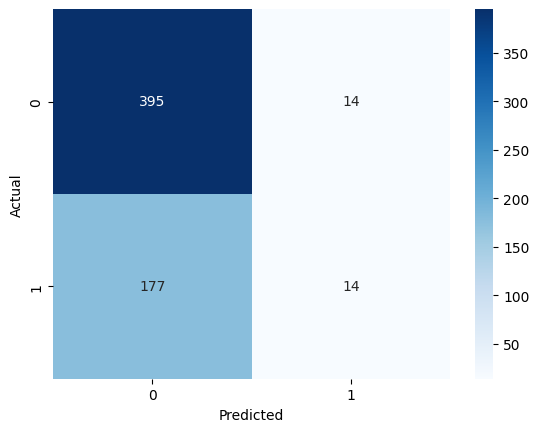

In [169]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [170]:
import joblib

# Save pipeline
joblib.dump(pipeline, "final_model.pkl")
print("Model saved as final_model.pkl")

Model saved as final_model.pkl
